In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [44]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

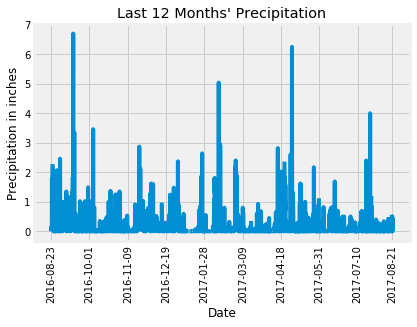

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
last12months_prcp = pd.DataFrame(data=prcp_data)
last12months_prcp.set_index('date', inplace=False)
last12months_prcp.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
dates = last12months_prcp["date"].sort_values()
prcp = last12months_prcp["prcp"]
plt.plot(prcp)

plt.title("Last 12 Months' Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation in inches")

labels=[dates[0],dates[250],dates[500],dates[750],dates[1000],dates[1250],dates[1500],dates[1750],dates[2000],dates[2222]]
loc=[0,250,500,750,1000,1250,1500,1750,2000,2222]

plt.xticks(loc,labels,rotation="vertical")
plt.savefig("Last 12 Months' Precipitation",dpi=80, bbox_inches = "tight")
plt.show()

![precipitation](Images/precipitation.png)

In [49]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last12months_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [50]:
# Design a query to show how many stations are available in this dataset
Number_of_Stations = session.query(func.count(Station.station)).first()
Number_of_Stations

(9)

In [41]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_data = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station = station_data[0][0]
print(f'The most active station is {most_active_station}')

The most active station is USC00519281


In [63]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tobs = (session
             .query(Measurement.date, Measurement.tobs)
             .filter(and_(Measurement.date > '2016-08-23'
                          ,Measurement.station == most_active_station)).order_by(Measurement.date).all())
tobs_df = pd.DataFrame(temp_obser, columns=['Date','Temp'])
tobs_df = tobs_df.set_index('Date')
tobs_df.head()

Min_Temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
Max_Temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
Avg_Temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()


print(f'The lowest temperature recorder from the most active station is {Min_Temp} degree.')
print(f'The highest temperature recorder from the most active station is {Max_Temp} degree.')
print(f'The average temperature recorder from the most active station is {Avg_Temp} degree.')


The lowest temperature recorder from the most active station is [(54.0,)] degree.
The highest temperature recorder from the most active station is [(85.0,)] degree.
The average temperature recorder from the most active station is [(71.66378066378067,)] degree.


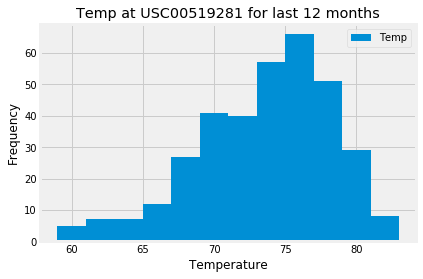

In [66]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_df.plot.hist(title = f'Temp at {most_active_station} for last 12 months',bins = 12)
plt.xlabel("Temperature")
plt.savefig("Temp at USC00519281",dpi=80, bbox_inches = "tight")
plt.show()

![precipitation](Images/station-histogram.png)

In [96]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [99]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.datetime(2016,11,18)
end_date = dt.datetime(2016,11,25)

cal_temp =calc_temps(start_date, end_date)

temp_stat = pd.DataFrame(cal_temp[:],columns=["Min","Avg","Max"])
temp_stat

,Min,Avg,Max
0,69.0,74.384615,80.0


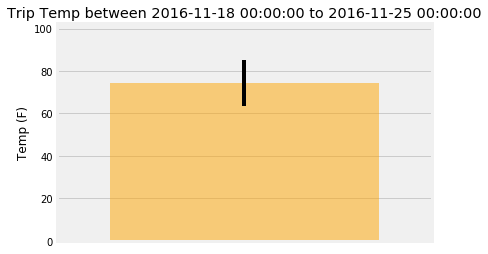

In [107]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = temp_stat['Max'] - temp_stat['Min']
x_axis=1 

fig, ax = plt.subplots()
plot_bar = ax.bar(x_axis,temp_stat['Avg'],yerr=yerr,color='orange',align='center',alpha=0.5)
ax.set(xticks=range(x_axis)
       ,title=f"Trip Temp between {start_date} to {end_date}"
       ,ylabel="Temp (F)")
ax.margins(.2,.2)
plt.savefig(f"Trip Temp between {start_date} to {end_date}",dpi=80, bbox_inches = "tight")
plt.show()

In [111]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
py_start_date = start_date - dt.timedelta(365)
py_end_date = end_date- dt.timedelta(365)


rain_data = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Measurement.prcp).\
    filter(Measurement.date.between(py_start_date,py_end_date)).\
    group_by(Measurement.station).\
    join(Station, Measurement.station==Station.station).\
    order_by(Measurement.prcp.desc()).all()

rain_df = pd.DataFrame(rain_data[:],columns=["Station ID","Station Name","Latitude","Longitude","Prcp"])
rain_df

,Station ID,Station Name,Latitude,Longitude,Prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,3.38
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,1.92
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,1.87
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,1.75
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,1.57
5,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,0.68
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,NaN
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,NaN


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
